# <b> INTRODUCTION <b>
The model is built upon PrithviT_100M, a pre-trained vision transformer backbone model, and is fine-tuned using the HLSBurnScars dataset. This combination provides the necessary architecture and data specificity to achieve high precision in recognizing burn scars across diverse geographical regions.The core of our model lies in its ability to perform a segmentation task, where each pixel in an image is classified as either burned or unburned. The model's application has broad potential across various industries, especially in sectors that require real-time analysis of land conditions. By accurately identifying burn scars, this tool can provide critical insights into post-disaster recovery, environmental management, and more.

**Real-World Applications**

**1.Disaster Response and Wildfire Management:** Our model’s ability to detect burned surfaces can significantly improve wildfire management strategies. Emergency response teams can use it for rapid assessment of fire-damaged areas, optimizing resource allocation and aiding in post-wildfire recovery efforts.

**2.Forest Management and Conservation:** Our model can help forest managers monitor burned areas and assess recovery over time. This can improve fire prevention strategies, track vegetation regrowth, and safeguard biodiversity in fire-prone regions.

**3.Climate Change Research:** Our model contributes to climate change research by helping track the increasing frequency of wildfires. It provides valuable data for studying deforestation, carbon emissions, and overall environmental impact due to fires.

**4.Agriculture and Land Use Planning:** In agriculture, my model can assist in evaluating how wildfires affect soil quality and crop production. It supports farmers in planning for soil restoration, future crop planting, and implementing fire prevention strategies.

**5.Insurance and Property Risk Assessment:** Our model offers value to the insurance industry by automating the identification of wildfire damage. It can be used for faster claims processing and more accurate property risk assessments in fire-prone areas.

# Importing the necessary libraries

In [1]:
import os
import timm
import torch
import terratorch 

/p/project1/training2431/musyoka1/gfm/env-jurecadc/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


**Checking prithvi pre-trained models**<br>
**Prithvi** means **Earth** in Sanskrit

In [2]:
print(timm.list_pretrained("prithvi*"))

['prithvi_vit_100']


# Creating the Backbone Model

As we are using images with no time stamp we set the num_frame to 1

In [3]:
my_model = timm.create_model('prithvi_vit_100',num_frames=1, pretrained=True, features_only=True) #creating an instance of the foundation model

In [4]:
#checking model specs(bands)
my_model.pretrained_bands

[<HLSBands.BLUE: 'BLUE'>,
 <HLSBands.GREEN: 'GREEN'>,
 <HLSBands.RED: 'RED'>,
 <HLSBands.NIR_NARROW: 'NIR_NARROW'>,
 <HLSBands.SWIR_1: 'SWIR_1'>,
 <HLSBands.SWIR_2: 'SWIR_2'>]

In [5]:
my_model.model_bands #using the same band as the training bands

[<HLSBands.BLUE: 'BLUE'>,
 <HLSBands.GREEN: 'GREEN'>,
 <HLSBands.RED: 'RED'>,
 <HLSBands.NIR_NARROW: 'NIR_NARROW'>,
 <HLSBands.SWIR_1: 'SWIR_1'>,
 <HLSBands.SWIR_2: 'SWIR_2'>]

# Defining Bands

Defining specific bands (e.g., Red, Green, NIR) is crucial for geospatial data processing because different spectral bands capture unique information about the Earth's surface. These bands help in accurately detecting land cover changes like burned areas through multi-spectral imagery analysis.

In [7]:
from terratorch.datasets import HLSBands
bands = [HLSBands.RED, HLSBands.GREEN, HLSBands.BLUE,  HLSBands.NIR_NARROW,HLSBands.SWIR_1,HLSBands.SWIR_2]

# Building the Segmentation Model

This block sets up the model for segmentation using a pre-trained "Prithvi" backbone and UperNet decoder, allowing it to handle geospatial data with the defined input channels (bands). Using a pre-trained model accelerates training and improves performance since it starts with weights learned from prior geospatial tasks.

In [8]:
from terratorch.models import PrithviModelFactory

# Let's build a segmentation model
# Parameters prefixed with backbone_ get passed to the backbone
# Parameters prefixed with decoder_ get passed to the decoder
# Parameters prefixed with head_ get passed to the head

model = PrithviModelFactory().build_model(
    task="segmentation",
    backbone="prithvi_vit_100",
    decoder="UperNetDecoder",  
    in_channels=6,
    bands=[
        HLSBands.BLUE,
        HLSBands.GREEN,
        HLSBands.RED,
        HLSBands.NIR_NARROW,
        HLSBands.SWIR_1,
        HLSBands.SWIR_2,
    ],
    num_classes=2,
    pretrained=True,
    num_frames=1,
    decoder_scale_modules=True,
    decoder_channels=128,
    head_dropout=0.2
)

# Loading and Visualizing the Dataset

Since I would like to have a view of some of the datapoints and their masked labels and also ensures my data is in the right format.Loading and visualizing the dataset ensures that the raster data is correctly interpreted and can be examined before training. Visualizing helps to confirm that the input data is as expected, allowing for early detection of issues like misaligned data or incorrect formats.

<xarray.DataArray (band: 6, y: 512, x: 512)> Size: 6MB
[1572864 values with dtype=float32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 4kB 2.82e+05 2.82e+05 ... 2.973e+05 2.973e+05
  * y            (y) float64 4kB 3.877e+06 3.877e+06 ... 3.861e+06 3.861e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0
(6, 512, 512)
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 4kB 2.82e+05 2.82e+05 ... 2.973e+05 2.973e+05
  * y            (y) float64 4kB 3.877e+06 3.877e+06 ... 3.861e+06 3.861e+06
    spatial_ref  int64 8B 0


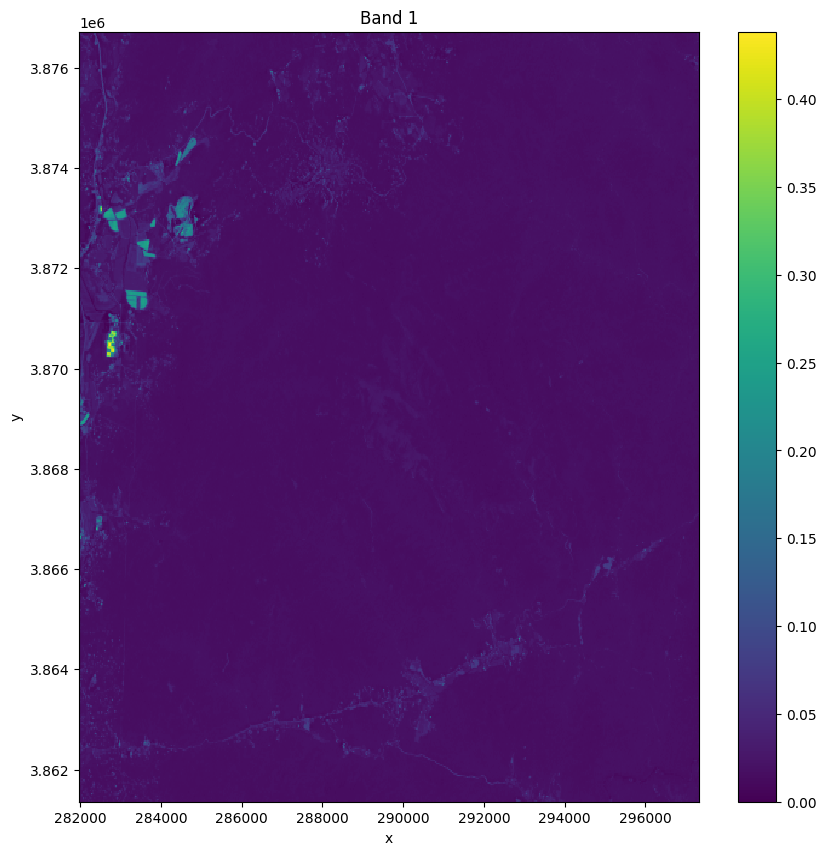

In [23]:
import rioxarray as rxr
import matplotlib.pyplot as plt

# Path to your uploaded dataset
file_path = '/p/project1/training2431/walter5/gfm/data/share/HLSBurnScars/validation/subsetted_512x512_HLS.S30.T17SKU.2021166.v1.4_merged.tif'  # Adjust this path

# Load the dataset
dataset = rxr.open_rasterio(file_path)

# Print dataset information
print(dataset)
print(dataset.shape)  # View dimensions
print(dataset.coords)  # View coordinates

# Visualize the first band
plt.figure(figsize=(10, 10))
dataset.sel(band=1).plot()  # Change the band number as needed
plt.title('Band 1')
plt.show()

# Visualizing the data label(mask image)

<xarray.DataArray (band: 1, y: 512, x: 512)> Size: 524kB
[262144 values with dtype=int16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 4kB 2.82e+05 2.82e+05 ... 2.973e+05 2.973e+05
  * y            (y) float64 4kB 3.877e+06 3.877e+06 ... 3.861e+06 3.861e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -1000
    scale_factor:   1.0
    add_offset:     0.0
(1, 512, 512)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 4kB 2.82e+05 2.82e+05 ... 2.973e+05 2.973e+05
  * y            (y) float64 4kB 3.877e+06 3.877e+06 ... 3.861e+06 3.861e+06
    spatial_ref  int64 8B 0


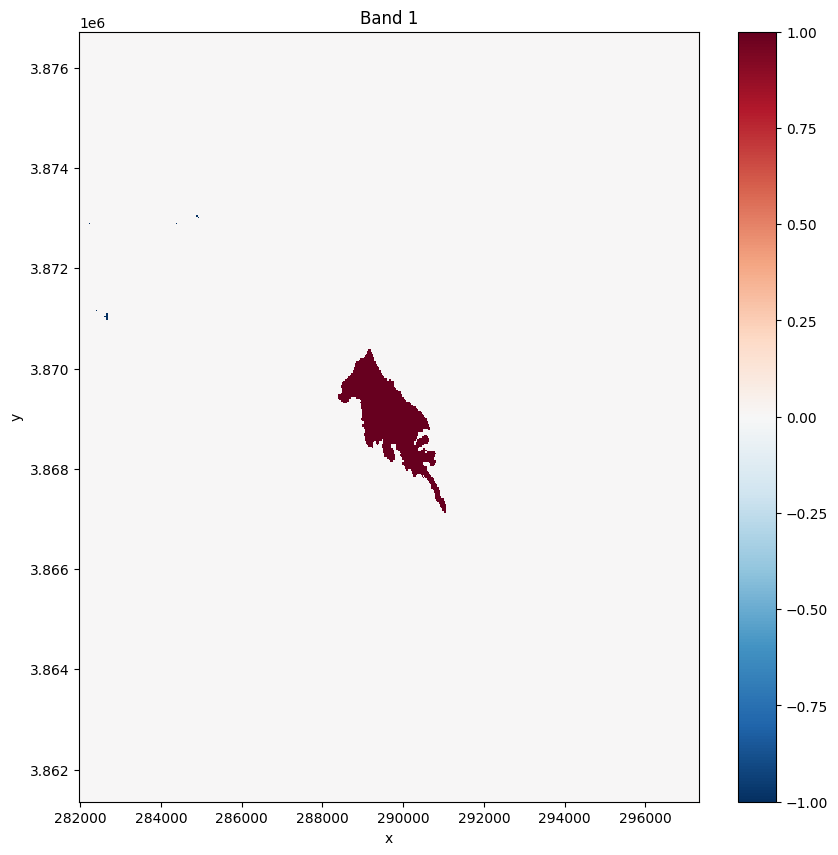

In [25]:
import rioxarray as rxr
import matplotlib.pyplot as plt

# Path to your uploaded dataset
file_path = '/p/project1/training2431/walter5/gfm/data/share/HLSBurnScars/validation/subsetted_512x512_HLS.S30.T17SKU.2021166.v1.4.mask.tif'  # Adjust this path

# Load the dataset
dataset = rxr.open_rasterio(file_path)

# Print dataset information
print(dataset)
print(dataset.shape)  # View dimensions
print(dataset.coords)  # View coordinates

# Visualize the first band
plt.figure(figsize=(10, 10))
dataset.sel(band=1).plot()  # Change the band number as needed
plt.title('Band 1')
plt.show()

# Setting Up Data Module

The data module organizes and processes the input data, preparing it for training and validation. It ensures the correct handling of the dataset, including batch size, normalizing the bands, and replacing missing data, which is essential for smooth and efficient training.

In [9]:
from terratorch.datamodules import GenericNonGeoSegmentationDataModule

# from https://github.com/NASA-IMPACT/hls-foundation-os/blob/main/configs/burn_scars.py
means=[
        0.033349706741586264,
        0.05701185520536176,
        0.05889748132001316,
        0.2323245113436119,
        0.1972854853760658,
        0.11944914225186566,
    ]
stds=[
        0.02269135568823774,
        0.026807560223070237,
        0.04004109844362779,
        0.07791732423672691,
        0.08708738838140137,
        0.07241979477437814,
    ]

datamodule = GenericNonGeoSegmentationDataModule(
    batch_size=10,
    num_workers=63,
    train_data_root="data/share/HLSBurnScars/training",
    val_data_root="data/share/HLSBurnScars/validation",
    test_data_root="data/share/HLSBurnScars/validation",
    img_grep="*_merged.tif",
    label_grep="*.mask.tif",
    means=means,
    stds=stds,
    num_classes=2,
    train_label_data_root="data/share/HLSBurnScars/training",  # Not needed with shared directory

    # if transforms are defined with Albumentations, you can pass them here
    # train_transform=train_transform,
    # val_transform=val_transform,
    # test_transform=test_transform,

    # Bands of your dataset
    dataset_bands=[
        HLSBands.BLUE,
        HLSBands.GREEN,
        HLSBands.RED,
        HLSBands.NIR_NARROW,
        HLSBands.SWIR_1,
        HLSBands.SWIR_2,
    ],
    
    # Input bands of your model
    output_bands=[
        HLSBands.BLUE,
        HLSBands.GREEN,
        HLSBands.RED,
        HLSBands.NIR_NARROW,
        HLSBands.SWIR_1,
        HLSBands.SWIR_2,
    ],
    no_data_replace=0,
    no_label_replace=-1,
)
# we want to access some properties of the train dataset later on, so lets call setup here
# if not, we would not need to
datamodule.setup("fit")

# Defining the Segmentation Task

Here we set up the actual task (semantic segmentation) by defining the model, loss function, learning rate, and optimizer. Class weights are added to address class imbalance (i.e., we have samples containing more datapoints for unburned surfaces as compared to burned surfaces), helping the model learn to prioritize minority classes.

In [10]:
from terratorch.tasks import SemanticSegmentationTask

model_args = {
        "backbone":"prithvi_vit_100",
        "decoder":"UperNetDecoder",
        "in_channels": 6,
        "num_classes": 2,
        "bands": [
            HLSBands.RED,
            HLSBands.GREEN,
            HLSBands.BLUE,
            HLSBands.NIR_NARROW,
            HLSBands.SWIR_1,
            HLSBands.SWIR_2,
        ],
        "pretrained": True,
        "num_frames":1,
        "decoder_channels":128,
        "head_dropout":0.2
}

task = SemanticSegmentationTask(
    model_args,
    "PrithviModelFactory",
    loss="ce",
    lr=1e-3,
    ignore_index=-1,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.03},
    freeze_backbone=True,
    class_names=['Not burned', 'Burned'],
    class_weights=[0.1, 0.9]
)

# Training the Model
The training loop is set up using PyTorch Lightning's Trainer, which helps in managing model training with added features like early stopping, logging, and checkpointing. This simplifies the training process while ensuring model improvements are monitored and saved for future use.

In [17]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
early_stopping_callback = EarlyStopping(monitor=task.monitor, min_delta=0.00, patience=16)
logger = TensorBoardLogger(save_dir='output', name='tutorial')

# You can also log directly to WandB
# from lightning.pytorch.loggers import WandbLogger
# wandb_logger = WandbLogger(log_model="all") 

trainer = Trainer(
        devices=1,
    accelerator="gpu",# Number of GPUs
    precision="16-mixed",
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    logger=logger,
    max_epochs=21, # train only one epoch for demo
    default_root_dir='output/tutorial',
    log_every_n_steps=2,
    check_val_every_n_epoch=1
)
_ = trainer.fit(model=task, datamodule=datamodule)

/p/project1/training2431/musyoka1/gfm/env-jurecadc/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /p/project1/training2431/musyoka1/gfm/env-jurecadc/l ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ PixelWiseModel   │ 87.4 M │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │
│ 2 │ train_metrics │ MetricCollection │      0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │
│ 4 │ test_metrics  │ MetricCollection │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 86.2 M                                                                                       
Total params: 87.4 M                                                                                               
Total estimated model params size (MB): 349

Output()

`Trainer.fit` stopped: `max_epochs=21` reached.


# Testing the Model
Testing the model on unseen data allows for the evaluation of its performance using key metrics like accuracy, F1 score, and Jaccard Index. This step is crucial to ensure the model generalizes well to new data, particularly in distinguishing burned from unburned areas.

This section of the model evaluates its performance on unseen data, focusing on key metrics that indicate how well it generalizes. Here’s a breakdown:

1.Multiclass Accuracy: The model achieves an accuracy of 96.76%, meaning it correctly identifies burned and unburned areas most of the time.

2.F1 Score: With a score of 96.76%, the model maintains a good balance between precision (correctly identified areas) and recall (finding all relevant areas).

3.Multiclass Jaccard Index: This index, at 83.16%, measures how closely the predicted and actual classifications match. A score above 80% indicates a strong similarity.

4.Test Loss: The model's error rate is 1.82. This value suggests the model is learning well.

5.Class-Specific Performance:For "Not Burned" areas, the model’s accuracy is 79.88%, and its Jaccard Index is 96.27%.

The model performs very well, especially in distinguishing burned areas

In [18]:
res = trainer.test(model=task, datamodule=datamodule)

/p/project1/training2431/musyoka1/gfm/env-jurecadc/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /p/project1/training2431/musyoka1/gfm/env-jurecadc/l ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Test metric               ┃              DataLoader 0              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/Multiclass_Accuracy        │           0.9657995700836182           │
│        test/Multiclass_F1_Score        │           0.9657995700836182           │
│     test/Multiclass_Jaccard_Index      │           0.8361803293228149           │
│  test/Multiclass_Jaccard_Index_Micro   │           0.9338610768318176           │
│               test/loss                │          0.16528873145580292           │
│     test/multiclassaccuracy_Burned     │           0.9031711220741272           │
│   test/multiclassaccuracy_Not burned   │           0.9721882343292236           │
│   test/multiclassjaccardindex_Burned   │           0.7096813321113586           │
│ test/multiclassjaccardindex_Not burned │           0.962679386138916            │
└────────────────────────────────────────┴────────────────────────────────────────┘